# 02 - Data Preprocessing

This notebook prepares the SOQG dataset for FLAN-T5 fine-tuning. We will:

1. Load and combine all data splits
2. Clean and deduplicate the data
3. Format inputs with instruction prefixes for FLAN-T5
4. Tokenize and validate sequence lengths
5. Save processed datasets for training

---

## FLAN-T5 Input Format

FLAN-T5 expects instruction-style inputs. Our format:

```
Input:  "Generate a Socratic question for this context: [context]"
Target: "[Question] [question text]"
```

## Google Colab Setup

Mount Google Drive to save processed data and models.

In [26]:
from google.colab import drive
drive.mount('/content/drive')

import os
DRIVE_ROOT = "/content/drive/MyDrive/socratic-path"
os.makedirs(DRIVE_ROOT, exist_ok=True)
print(f"Google Drive mounted at: {DRIVE_ROOT}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted at: /content/drive/MyDrive/socratic-path


## Setup and Imports

In [27]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
from tqdm.auto import tqdm
from transformers import T5Tokenizer
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
import seaborn as sns

tqdm.pandas()

In [3]:
!git clone https://github.com/NUS-IDS/eacl23_soqg.git ../datasets/raw/soqg

Cloning into '../datasets/raw/soqg'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 254 (delta 31), reused 114 (delta 30), pack-reused 136 (from 1)
Receiving objects: 100% (254/254), 40.70 MiB | 21.40 MiB/s, done.
Resolving deltas: 100% (66/66), done.


## Configuration

In [28]:
DATA_DIR = Path("../datasets/raw/soqg/data/soqg_dataset")
OUTPUT_DIR = Path(DRIVE_ROOT) / "datasets/processed"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "google/flan-t5-base"
MAX_SOURCE_LENGTH = 400
MAX_TARGET_LENGTH = 80

INSTRUCTION_PREFIX = "Generate a Socratic question for this context: "
TARGET_PREFIX = "[Question] "

RANDOM_SEED = 42

print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

Data directory: ../datasets/raw/soqg/data/soqg_dataset
Output directory: /content/drive/MyDrive/socratic-path/datasets/processed


## Load Raw Data

In [5]:
train_files = ["train_chunk_I.csv", "train_chunk_II.csv", "train_chunk_III.csv"]
train_chunks = [pd.read_csv(DATA_DIR / f, index_col=0) for f in train_files if (DATA_DIR / f).exists()]
train_df = pd.concat(train_chunks, axis=0, ignore_index=True)

valid_df = pd.read_csv(DATA_DIR / "valid.csv", index_col=0)
test_df = pd.read_csv(DATA_DIR / "test.csv", index_col=0)

print(f"Raw sizes -> Train: {len(train_df)}, Valid: {len(valid_df)}, Test: {len(test_df)}")

Raw sizes -> Train: 84582, Valid: 10573, Test: 10573


## Data Cleaning

In [6]:
def clean_text(text):
    """Basic text cleaning."""
    if pd.isna(text):
        return ""
    text = str(text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

In [7]:
print("Cleaning training data...")
train_df['input'] = train_df['input'].progress_apply(clean_text)
train_df['target'] = train_df['target'].progress_apply(clean_text)

print("Cleaning validation data...")
valid_df['input'] = valid_df['input'].apply(clean_text)
valid_df['target'] = valid_df['target'].apply(clean_text)

print("Cleaning test data...")
test_df['input'] = test_df['input'].apply(clean_text)
test_df['target'] = test_df['target'].apply(clean_text)

Cleaning training data...


  0%|          | 0/84582 [00:00<?, ?it/s]

  0%|          | 0/84582 [00:00<?, ?it/s]

Cleaning validation data...
Cleaning test data...


## Remove Empty and Duplicate Rows

In [8]:
initial_train = len(train_df)

train_df = train_df[(train_df['input'].str.len() > 10) & (train_df['target'].str.len() > 5)]
valid_df = valid_df[(valid_df['input'].str.len() > 10) & (valid_df['target'].str.len() > 5)]
test_df = test_df[(test_df['input'].str.len() > 10) & (test_df['target'].str.len() > 5)]

train_df = train_df.drop_duplicates(subset=['input', 'target'])
valid_df = valid_df.drop_duplicates(subset=['input', 'target'])
test_df = test_df.drop_duplicates(subset=['input', 'target'])

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"Train: {initial_train} -> {len(train_df)} (removed {initial_train - len(train_df)})")
print(f"Valid: {len(valid_df)}, Test: {len(test_df)}")

Train: 84582 -> 84582 (removed 0)
Valid: 10573, Test: 10573


## Format for FLAN-T5

We add instruction prefixes to help the model understand the task. The target includes a `[Question]` token as used in the original paper.

In [9]:
def format_for_flan_t5(row):
    """Format input and target for FLAN-T5 instruction tuning."""
    formatted_input = INSTRUCTION_PREFIX + row['input']
    formatted_target = TARGET_PREFIX + row['target']
    return pd.Series({
        'input_text': formatted_input,
        'target_text': formatted_target,
        'original_input': row['input'],
        'original_target': row['target']
    })

In [10]:
print("Formatting training data...")
train_formatted = train_df.progress_apply(format_for_flan_t5, axis=1)

print("Formatting validation data...")
valid_formatted = valid_df.apply(format_for_flan_t5, axis=1)

print("Formatting test data...")
test_formatted = test_df.apply(format_for_flan_t5, axis=1)

Formatting training data...


  0%|          | 0/84582 [00:00<?, ?it/s]

Formatting validation data...
Formatting test data...


In [11]:
print("Sample formatted input:")
print("-" * 50)
print(train_formatted.iloc[0]['input_text'][:300])
print("\nSample formatted target:")
print("-" * 50)
print(train_formatted.iloc[0]['target_text'])

Sample formatted input:
--------------------------------------------------
Generate a Socratic question for this context: alternate_viewpoints_perspectives: A parallel argument would state that England is worse off because America passed them as the dominant economic power in the world. Is the argument remotely true? Not at all - England has become far wealthier from trade

Sample formatted target:
--------------------------------------------------
[Question] What about nations who have nothing?


## Initialize Tokenizer

We add the `[Question]` special token to the tokenizer as done in the original training script.

In [12]:
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
tokenizer.add_tokens(["[Question]"])

print(f"Vocabulary size: {len(tokenizer)}")
print(f"[Question] token ID: {tokenizer.convert_tokens_to_ids('[Question]')}")

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Vocabulary size: 32101
[Question] token ID: 32100


## Analyze Token Lengths

In [13]:
def count_tokens(text):
    return len(tokenizer.encode(text, add_special_tokens=True))

sample_size = min(5000, len(train_formatted))
sample_df = train_formatted.sample(sample_size, random_state=RANDOM_SEED)

print("Counting tokens in sample...")
sample_df['input_tokens'] = sample_df['input_text'].progress_apply(count_tokens)
sample_df['target_tokens'] = sample_df['target_text'].progress_apply(count_tokens)

Counting tokens in sample...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

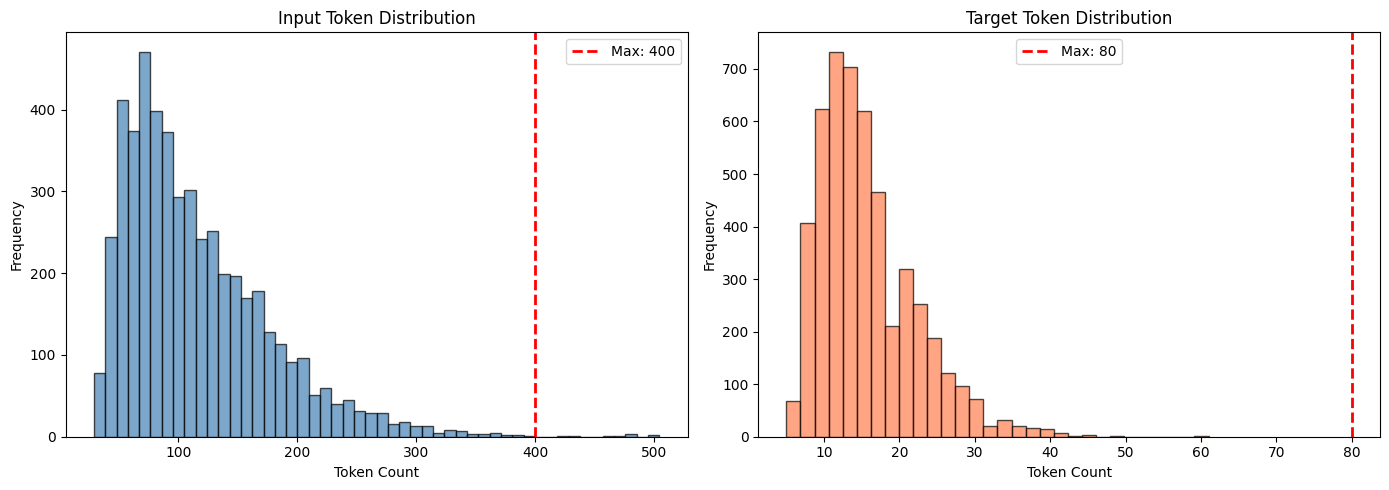


Inputs exceeding 400 tokens: 9 (0.2%)
Targets exceeding 80 tokens: 0 (0.0%)


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(sample_df['input_tokens'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(MAX_SOURCE_LENGTH, color='red', linestyle='--', linewidth=2, label=f'Max: {MAX_SOURCE_LENGTH}')
axes[0].set_title('Input Token Distribution')
axes[0].set_xlabel('Token Count')
axes[0].set_ylabel('Frequency')
axes[0].legend()

axes[1].hist(sample_df['target_tokens'], bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[1].axvline(MAX_TARGET_LENGTH, color='red', linestyle='--', linewidth=2, label=f'Max: {MAX_TARGET_LENGTH}')
axes[1].set_title('Target Token Distribution')
axes[1].set_xlabel('Token Count')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

truncated_inputs = (sample_df['input_tokens'] > MAX_SOURCE_LENGTH).sum()
truncated_targets = (sample_df['target_tokens'] > MAX_TARGET_LENGTH).sum()
print(f"\nInputs exceeding {MAX_SOURCE_LENGTH} tokens: {truncated_inputs} ({truncated_inputs/sample_size*100:.1f}%)")
print(f"Targets exceeding {MAX_TARGET_LENGTH} tokens: {truncated_targets} ({truncated_targets/sample_size*100:.1f}%)")

## Tokenization Function

In [15]:
def tokenize_function(examples):
    """Tokenize inputs and targets for FLAN-T5."""
    model_inputs = tokenizer(
        examples['input_text'],
        max_length=MAX_SOURCE_LENGTH,
        truncation=True,
        padding='max_length'
    )

    labels = tokenizer(
        examples['target_text'],
        max_length=MAX_TARGET_LENGTH,
        truncation=True,
        padding='max_length'
    )

    model_inputs['labels'] = labels['input_ids']
    return model_inputs

## Create HuggingFace Datasets

In [16]:
train_dataset = Dataset.from_pandas(train_formatted[['input_text', 'target_text']])
valid_dataset = Dataset.from_pandas(valid_formatted[['input_text', 'target_text']])
test_dataset = Dataset.from_pandas(test_formatted[['input_text', 'target_text']])

print(f"Train dataset: {len(train_dataset)} samples")
print(f"Valid dataset: {len(valid_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")

Train dataset: 84582 samples
Valid dataset: 10573 samples
Test dataset: 10573 samples


In [17]:
print("Tokenizing training dataset...")
train_tokenized = train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=['input_text', 'target_text'],
    desc="Tokenizing train"
)

print("Tokenizing validation dataset...")
valid_tokenized = valid_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=['input_text', 'target_text'],
    desc="Tokenizing valid"
)

print("Tokenizing test dataset...")
test_tokenized = test_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=['input_text', 'target_text'],
    desc="Tokenizing test"
)

Tokenizing training dataset...


Tokenizing train:   0%|          | 0/84582 [00:00<?, ? examples/s]

Tokenizing validation dataset...


Tokenizing valid:   0%|          | 0/10573 [00:00<?, ? examples/s]

Tokenizing test dataset...


Tokenizing test:   0%|          | 0/10573 [00:00<?, ? examples/s]

In [18]:
print("Tokenized dataset features:")
print(train_tokenized.features)

Tokenized dataset features:
{'input_ids': List(Value('int32')), 'attention_mask': List(Value('int8')), 'labels': List(Value('int64'))}


## Save Processed Datasets

In [21]:
dataset_dict = DatasetDict({
    'train': train_tokenized,
    'validation': valid_tokenized,
    'test': test_tokenized
})

dataset_path = OUTPUT_DIR / "soqg_tokenized"
dataset_dict.save_to_disk(str(dataset_path))
print(f"Saved tokenized datasets to: {dataset_path}")

Saving the dataset (0/1 shards):   0%|          | 0/84582 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10573 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10573 [00:00<?, ? examples/s]

Saved tokenized datasets to: /content/drive/MyDrive/socratic-path/datasets/processed/soqg_tokenized


In [22]:
train_formatted.to_parquet(OUTPUT_DIR / "train_formatted.parquet")
valid_formatted.to_parquet(OUTPUT_DIR / "valid_formatted.parquet")
test_formatted.to_parquet(OUTPUT_DIR / "test_formatted.parquet")

print("Saved formatted DataFrames as Parquet files.")

Saved formatted DataFrames as Parquet files.


In [23]:
tokenizer.save_pretrained(OUTPUT_DIR / "tokenizer")
print(f"Saved tokenizer with [Question] token to: {OUTPUT_DIR / 'tokenizer'}")

Saved tokenizer with [Question] token to: /content/drive/MyDrive/socratic-path/datasets/processed/tokenizer


## Verify Saved Data

In [24]:
from datasets import load_from_disk

loaded_dataset = load_from_disk(str(dataset_path))
print("Loaded dataset splits:", loaded_dataset)

sample = loaded_dataset['train'][0]
print("\nSample input_ids shape:", len(sample['input_ids']))
print("Sample labels shape:", len(sample['labels']))

Loaded dataset splits: DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 84582
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10573
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10573
    })
})

Sample input_ids shape: 400
Sample labels shape: 80


In [25]:
decoded_input = tokenizer.decode(sample['input_ids'], skip_special_tokens=True)
decoded_target = tokenizer.decode(sample['labels'], skip_special_tokens=True)

print("Decoded input:")
print(decoded_input[:200] + "...")
print("\nDecoded target:")
print(decoded_target)

Decoded input:
Generate a Socratic question for this context: alternate_viewpoints_perspectives: A parallel argument would state that England is worse off because America passed them as the dominant economic power i...

Decoded target:
[Question] What about nations who have nothing?


## Preprocessing Summary

| Output File | Description |
|-------------|-------------|
| `processed/soqg_tokenized/` | HuggingFace Dataset (ready for training) |
| `processed/train_formatted.parquet` | Formatted text data |
| `processed/valid_formatted.parquet` | Formatted validation data |
| `processed/test_formatted.parquet` | Formatted test data |
| `processed/tokenizer/` | Tokenizer with [Question] token |

---

**Next Step**: Proceed to `03_training.ipynb` to fine-tune FLAN-T5 on the processed data.